# Load Data

In [61]:
import os
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from itertools import combinations
from collections import defaultdict
from joblib import Parallel, delayed
import joblib
from itertools import combinations
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedShuffleSplit

# === Load Data ===
folder_path = "C:\\Users\\Franc\\repos\\TradingAI\\data\\"
column_names = ['datetime', 'open', 'high', 'low', 'close', 'volume']
df_list = []

for filename in os.listdir(folder_path):
    if filename.endswith(('.csv', '.txt')):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep=';', header=None, names=column_names)
        df['source_file'] = filename
        df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df['datetime'] = pd.to_datetime(df['datetime'])
# Resample to 5-minute candles
df = df.sort_values('datetime').reset_index(drop=True)
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

# Base time features
df['hour'] = df['datetime'].dt.hour + df['datetime'].dt.minute / 60
df['minute'] = df['datetime'].dt.minute
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0 = Monday

# Custom session flags (adjust if needed)       # Regular Trading Hours
df['is_premarket'] = df['hour'].between(7, 9.5)
df['is_lunch'] = df['hour'].between(11.5, 13.5)


# Initialize features or indicators

In [62]:
# === Feature Engineering ===
df['ema_9'] = ta.ema(df['close'], length=9)
df['ema_21'] = ta.ema(df['close'], length=21)
df['rsi'] = ta.rsi(df['close'], length=14)
df['atr_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)
macd = ta.macd(df['close'])
df['macd'] = macd['MACDh_12_26_9']
df['vwap'] = (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).cumsum() / df['volume'].cumsum()
df['vwap_diff'] = df['close'] - df['vwap']
# Volume delta proxy
df['volume_delta'] = np.where(df['close'] > df['open'], df['volume'], -df['volume'])
df['volume_delta_ema'] = df['volume_delta'].ewm(span=14).mean()

# # Candle body and total range
df['candle_body'] = abs(df['close'] - df['open'])
df['candle_range'] = df['high'] - df['low'] + 1e-9  # avoid division by zero

# # Candle body % of range
df['body_pct'] = df['candle_body'] / df['candle_range']

# # Wick sizes (relative to range)
df['upper_wick'] = (df['high'] - df[['close', 'open']].max(axis=1)) / df['candle_range']
df['lower_wick'] = (df[['close', 'open']].min(axis=1) - df['low']) / df['candle_range']


def choppiness_index(high, low, close, length=14):
    tr = ta.true_range(high=high, low=low, close=close)
    atr_sum = tr.rolling(length).sum()
    high_max = high.rolling(length).max()
    low_min = low.rolling(length).min()
    return 100 * np.log10(atr_sum / (high_max - low_min)) / np.log10(length)

# === Add Feature ===
df['chop_index'] = choppiness_index(df['high'], df['low'], df['close'])

# === Strategy Setup ===
df = df.dropna().reset_index(drop=True)
TICK_VALUE = 5
SL_ATR_MULT = 1.0
TP_ATR_MULT = 3.0
TRAIL_START_MULT = 2.5
TRAIL_STOP_MULT = 1.0
MAX_CONTRACTS = 1
thresholds = [0.005, 0.01, 0.015, 0.02, 0.025]
confidence_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

features = [
    'rsi', 'macd', 'ema_9', 'ema_21', 'volume', 'chop_index',
    'atr_14', 'vwap_diff', 
    'body_pct',  
    'upper_wick', 'lower_wick',  # just added
    'volume_delta_ema'
]

feature_funcs = {
    'rsi': lambda r: True,  # placeholder, actual check done per direction
    'macd': lambda r: True,
    'ema_cross': lambda r: True,
    'atr_14': lambda r: True,
    'chop_index': lambda r: r['chop_index'] < 60,
    'volume_delta_ema': lambda r: r['volume_delta_ema'] > 0,
    'vwap_diff': lambda r: r['vwap_diff'] < -40,
    'body_pct': lambda r: r['body_pct'] > 0.5,
    'upper_wick': lambda r: r['upper_wick'] > 0.5,
    'lower_wick': lambda r: r['lower_wick'] > 0.5,
}

avoid_funcs = {
}

def is_same_session(start_time, end_time):
    session_start = start_time.replace(hour=18, minute=0, second=0)
    if start_time.hour < 18:
        session_start -= timedelta(days=1)
    session_end = session_start + timedelta(hours=23)
    return session_start <= start_time <= session_end and session_start <= end_time <= session_end

combo_trades = defaultdict(set)

def combo_overlap(c1, c2):
    a, b = combo_trades[frozenset(c1)], combo_trades[frozenset(c2)]
    if not a or not b:
        return 1.0
    return len(a & b) / min(len(a), len(b))

# Declare Combo function for serialization

# Train & Evaluate

In [64]:
combo_stats = []
skipped_trades = 0

LOOKAHEAD = 12  # Lookahead bars to simulate trade outcome. Try [6, 10, 15, 20]
df['mfe'], df['mae'], df['rr_label'] = np.nan, np.nan, np.nan

for idx in range(len(df) - LOOKAHEAD):
    entry_price = df.loc[idx, 'close']
    high_slice = df.loc[idx+1:idx+LOOKAHEAD, 'high']
    low_slice = df.loc[idx+1:idx+LOOKAHEAD, 'low']

    # Long trade RR
    long_mfe = high_slice.max() - entry_price
    long_mae = entry_price - low_slice.min()
    long_rr = long_mfe / (long_mae + 1e-9)

    # Short trade RR
    short_mfe = entry_price - low_slice.min()
    short_mae = high_slice.max() - entry_price
    short_rr = short_mfe / (short_mae + 1e-9)

    # Choose better RR direction
    if long_rr >= short_rr:
        df.loc[idx, 'mfe'] = long_mfe
        df.loc[idx, 'mae'] = long_mae
        rr = long_rr
        direction = 'long'
    else:
        df.loc[idx, 'mfe'] = short_mfe
        df.loc[idx, 'mae'] = short_mae
        rr = short_rr
        direction = 'short'

    # Labeling (positive = long, negative = short)
    if rr >= 2.0:
        label = 2 if direction == 'long' else -2
    elif rr >= 1.2:
        label = 1 if direction == 'long' else -1
    elif rr > 0.8:
        label = 0  # Ambiguous, could be filtered out later
    else:
        label = -3  # Optional: new label for bad trades of either direction

    df.loc[idx, 'rr_label'] = label
    df.loc[idx, 'trade_dir'] = direction


labeled = df.dropna(subset=['rr_label']).copy()
X = labeled[features]
y = labeled['rr_label']
cutoff_date = pd.to_datetime("2025-01-01")
df_filtered = df[~df['rr_label'].isin([0, -3])].copy()

train = df[df['datetime'] < cutoff_date].dropna(subset=['rr_label'])
test = df[df['datetime'] >= cutoff_date].dropna(subset=['rr_label'])

X_train, y_train = train[features], train['rr_label']
X_test, y_test = test[features], test['rr_label']

# --- Model Training ---
param_dist = {
    'n_estimators': [400, 600, 800, 1000, 2000],
    'max_depth': [None, 5, 15, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
scorer = make_scorer(f1_score, average='weighted')
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    scoring=scorer,
    n_iter=30,
    cv=3,
    verbose=1,
    n_jobs=-1
)
# model = RandomForestClassifier(n_estimators=500, max_depth=12, min_samples_leaf=15, max_features='log2', class_weight='balanced_subsample', bootstrap=True, random_state=42)
#model.fit(X_train, y_train)
search.fit(X_train, y_train)
joblib.dump(search, f"rf_model_{cutoff_date.strftime('%Y%m%d')}.pkl")

# --- Feature Importance Ranking ---
importances = search.best_estimator_.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 2. Predict class and get probability
probs = search.predict_proba(X_test)  # shape: (n_samples, num_classes)
preds = search.predict(X_test)
class_mapping = search.classes_.tolist()  # e.g., [-2, -1, 0, 1, 2]

longs = X_test[preds == 2]
shorts = X_test[preds == -2]

print("\n📊 Average Indicator Values:")
print("📈 Long Trades:")
print(longs.mean().round(2))
print("\n📉 Short Trades:")
print(shorts.mean().round(2))

print("\n📌 Feature Importances:")
print(importance_df)




Fitting 3 folds for each of 30 candidates, totalling 90 fits

📊 Average Indicator Values:
📈 Long Trades:
rsi                    48.43
macd                   -0.36
ema_9               20125.54
ema_21              20126.75
volume                418.99
chop_index             49.60
atr_14                 13.80
vwap_diff             447.22
body_pct                0.47
upper_wick              0.27
lower_wick              0.27
volume_delta_ema      -20.82
dtype: float64

📉 Short Trades:
rsi                    52.48
macd                    0.39
ema_9               20745.24
ema_21              20744.07
volume                491.89
chop_index             49.66
atr_14                 10.53
vwap_diff            1092.37
body_pct                0.47
upper_wick              0.25
lower_wick              0.28
volume_delta_ema       14.41
dtype: float64

📌 Feature Importances:
             feature  importance
6             atr_14    0.095468
0                rsi    0.093511
1               macd    0.093

In [79]:
def evaluate_combo(
    X_test, preds, probs, class_mapping, labeled, df,
    avoid_funcs,
    SL_ATR_MULT, TP_ATR_MULT, TRAIL_START_MULT, TRAIL_STOP_MULT, TICK_VALUE,
    is_same_session
):
    conf_perf = defaultdict(lambda: {'wins': 0, 'losses': 0, 'total': 0, 'pnl': 0})
    conf_values = []
    temp_trades_data = []
    hourly_perf = defaultdict(lambda: {'wins': 0, 'losses': 0, 'total': 0, 'pnl': 0})
    skipped_trades = 0
    avoid_hits = defaultdict(int)
    long_trades = 0
    short_trades = 0
    skip_rr_stats = defaultdict(lambda: {'count': 0, 'rr_sum': 0.0, 'good': 0, 'bad': 0})


    for i, idx in enumerate(X_test.index):
        row = labeled.loc[idx]
        pred_class = preds[i]
        prob_vector = probs[i]
        class_index = class_mapping.index(pred_class)
        class_prob = prob_vector[class_index]

        is_trade = pred_class in [2, -2]

        if not is_trade or idx >= len(df) - 6:
            continue
        
        skip_trade = False
        for name, f in avoid_funcs.items():
            try:
                if f(row):
                    avoid_hits[name] += 1
                    skip_trade = True
            except:
                continue

        if skip_trade:
            skipped_trades += 1

            # Simulate what would’ve happened if we didn’t skip this trade
            entry_price = row['close']
            side = 'long' if pred_class in [2, 1] else 'short'
            atr = row['atr_14']
            sl_price = entry_price - SL_ATR_MULT * atr if side == 'long' else entry_price + SL_ATR_MULT * atr
            tp_price = entry_price + TP_ATR_MULT * atr if side == 'long' else entry_price - TP_ATR_MULT * atr
            max_price, min_price = entry_price, entry_price

            for fwd in range(1, 6):
                fwd_idx = idx + fwd
                if fwd_idx >= len(df): break
                fwd_row = df.loc[fwd_idx]
                max_price = max(max_price, fwd_row['high'])
                min_price = min(min_price, fwd_row['low'])

            mfe = max_price - entry_price if side == 'long' else entry_price - min_price
            mae = entry_price - min_price if side == 'long' else max_price - entry_price
            
            rr_ratio = mfe / (mae + 1e-9)

            # Track RR stats per avoid reason
            for name, f in avoid_funcs.items():
                try:
                    if f(row):
                        skip_rr_stats[name]['count'] += 1
                        skip_rr_stats[name]['rr_sum'] += rr_ratio
                        if rr_ratio >= 1.2:
                            skip_rr_stats[name]['good'] += 1
                        else:
                            skip_rr_stats[name]['bad'] += 1
                except:
                    continue

            continue


        conf_values.append(class_prob)

        entry_price = row['close']
        entry_time = row['datetime']
        side = 'long' if pred_class in [2, 1] else 'short'

        if pred_class in [2, 1]: 
            long_trades+=1 
        else:
            short_trades+=1 

        atr = row['atr_14']

        sl_price = entry_price - SL_ATR_MULT * atr if side == 'long' else entry_price + SL_ATR_MULT * atr
        tp_price = entry_price + TP_ATR_MULT * atr if side == 'long' else entry_price - TP_ATR_MULT * atr
        trail_trigger = entry_price + TRAIL_START_MULT * atr if side == 'long' else entry_price - TRAIL_START_MULT * atr
        trail_stop = None

        max_price, min_price = entry_price, entry_price
        exit_price, exit_time = None, None

        fwd_idx = idx + 1
        while fwd_idx < len(df):
            fwd_row = df.loc[fwd_idx]
            max_price = max(max_price, fwd_row['high'])
            min_price = min(min_price, fwd_row['low'])

            # SL hit
            if (side == 'long' and fwd_row['low'] <= sl_price) or (side == 'short' and fwd_row['high'] >= sl_price):
                exit_price = sl_price
                exit_time = fwd_row['datetime']
                break

            # TP hit
            if (side == 'long' and fwd_row['high'] >= tp_price) or (side == 'short' and fwd_row['low'] <= tp_price):
                exit_price = tp_price
                exit_time = fwd_row['datetime']
                break

            # Breakeven/trailing
            if side == 'long' and fwd_row['high'] >= trail_trigger:
                trail_stop = fwd_row['close'] - TRAIL_STOP_MULT * atr
            if side == 'short' and fwd_row['low'] <= trail_trigger:
                trail_stop = fwd_row['close'] + TRAIL_STOP_MULT * atr

            if trail_stop:
                if (side == 'long' and fwd_row['low'] <= trail_stop) or (side == 'short' and fwd_row['high'] >= trail_stop):
                    exit_price = trail_stop
                    exit_time = fwd_row['datetime']
                    break

            fwd_idx += 1

        # Safety fallback if none of the conditions were hit
        if exit_price is None:
            exit_price = df.loc[len(df) - 1, 'close']
            exit_time = df.loc[len(df) - 1, 'datetime']

        # Skip if trade crossed sessions
        if not is_same_session(entry_time, exit_time):
            continue

        GROSS_PNL = (exit_price - entry_price) * TICK_VALUE if side == 'long' else (entry_price - exit_price) * TICK_VALUE
        COMMISSION = 3.98
        pnl = GROSS_PNL - COMMISSION

        mfe = max_price - entry_price if side == 'long' else entry_price - min_price
        mae = entry_price - min_price if side == 'long' else max_price - entry_price


        temp_trades_data.append({
            'pnl': pnl,
            'mfe': mfe,
            'mae': mae,
            'gross_pnl': GROSS_PNL
        })

    results = pd.DataFrame(temp_trades_data)
    if results.empty:
        results = pd.DataFrame(columns=['pnl', 'mfe', 'mae', 'gross_pnl'])
    pnl_total = results['pnl'].sum() if not results.empty else 0
    trades = len(results)
    win_rate = (results['pnl'] > 0).mean() if not results.empty else 0
    avg_mfe = results['mfe'].mean() if not results.empty else 0
    avg_mae = results['mae'].mean() if not results.empty else 0
    max_win = results['pnl'].max() if not results.empty else 0
    max_loss = results['pnl'].min() if not results.empty else 0

    wins = results[results['pnl'] > 0]['pnl']
    losses = results[results['pnl'] < 0]['pnl']

    expectancy = wins.mean() * (len(wins) / trades) - abs(losses.mean()) * (len(losses) / trades) if trades else 0
    profit_factor = wins.sum() / abs(losses.sum()) if not losses.empty else np.nan
    sharpe = results['pnl'].mean() / (results['pnl'].std() + 1e-9) * np.sqrt(trades) if trades else 0

    return {
        'pnl': pnl_total,
        'trades': trades,
        'win_rate': win_rate,
        'avg_mfe': avg_mfe,
        'avg_mae': avg_mae,
        'max_win': max_win,
        'max_loss': max_loss,
        'expectancy': expectancy,
        'profit_factor': profit_factor,
        'sharpe': sharpe,
        'results': results,
        'long_trades': long_trades,
        'short_trades': short_trades,
        'avg_conf': np.mean(conf_values) if conf_values else 0,
        'min_conf': np.min(conf_values) if conf_values else 0,
        'max_conf': np.max(conf_values) if conf_values else 0,
        'conf_perf': dict(conf_perf),
        'avoid_hits': dict(avoid_hits),
        'skip_rr_stats': dict(skip_rr_stats),
        'hourly_perf': dict(hourly_perf),
    }


# Test Model

In [ ]:
results = evaluate_combo(
            X_test=X_test,
            preds=preds,
            probs=probs,
            class_mapping=class_mapping,
            labeled=labeled,
            df=df,
            avoid_funcs=avoid_funcs,
            SL_ATR_MULT=SL_ATR_MULT,
            TP_ATR_MULT=TP_ATR_MULT,
            TRAIL_START_MULT=TRAIL_START_MULT,
            TRAIL_STOP_MULT=TRAIL_STOP_MULT,
            TICK_VALUE=TICK_VALUE,
            is_same_session=is_same_session
        )

combo_stats.extend(results)

print("\n🛑 Avoid Filters Triggered Most Often:")
for name, count in sorted(results['avoid_hits'].items(), key=lambda x: -x[1]):
    print(f"{name}: {count}")

total_skip_stats = defaultdict(lambda: {'count': 0, 'rr_sum': 0.0, 'good': 0, 'bad': 0})
for r in results:
    for k, v in r.get('skip_rr_stats', {}).items():
        total_skip_stats[k]['count'] += v['count']
        total_skip_stats[k]['rr_sum'] += v['rr_sum']
        total_skip_stats[k]['good'] += v['good']
        total_skip_stats[k]['bad'] += v['bad']

print("\n📉 Avoid Rule Impact on Skipped Trades:")
for name, stats in sorted(results['skip_rr_stats'].items(), key=lambda x: -x[1]['count']):
    total = stats['count']
    avg_rr = stats['rr_sum'] / total if total else 0
    win_rate = stats['good'] / total if total else 0
    print(f"{name:<25} | Skipped={total:<5} | Avg RR={avg_rr:.2f} | SimWinRate={win_rate:.2%}")

print("\n⏰ Hourly Trade Performance:")
for hour in sorted(results['hourly_perf']):
    stats = results['hourly_perf'][hour]
    total = stats['total']
    win_rate = stats['wins'] / total if total else 0
    avg_pnl = stats['pnl'] / total if total else 0
    print(f"{hour:02d}:00 | Trades={total:<5} | WinRate={win_rate:.2%} | AvgPnL=${avg_pnl:.2f}")

print(f"\n📊 Summary:")
print(f"Total PnL: ${results['pnl']:.2f}")
print(f"Total Trades: {results['trades']}")
print(f"Win Rate: {results['win_rate']:.2%}")



AttributeError: 'str' object has no attribute 'get'

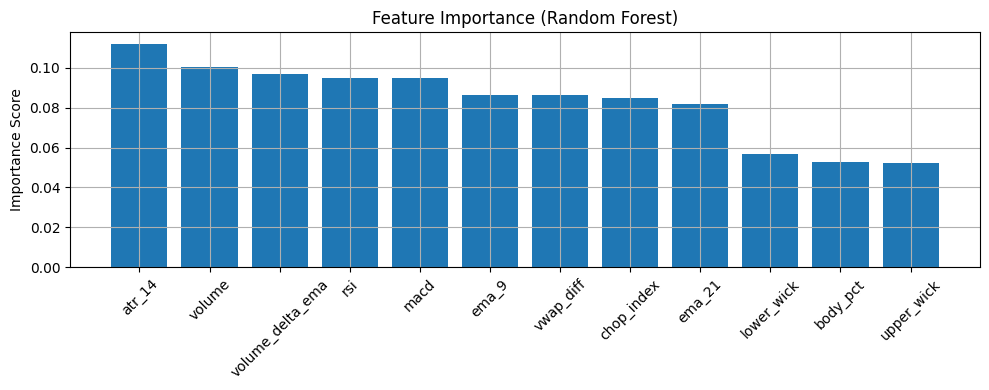

In [ ]:
plt.figure(figsize=(10, 4))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Sort and Plot


🏆 Best Overall Threshold: 0.005
📈 Best Overall Confidence: 0.1
✅ Exported best strategy configuration to `best_strategy.json`

🔥 Top Combo #1 | Confidence=0.1: ['rsi', 'chop_index', 'volume_delta_ema'] | PnL=$-169190.87, Trades=20593, WinRate=27.91%, MFE=32.04, MAE=10.68, MaxWin=$1323.42, MaxLoss=$-706.46


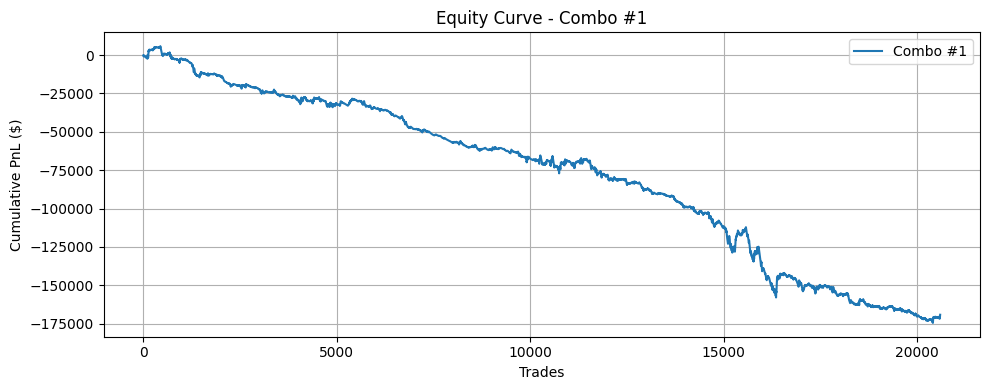


🔥 Top Combo #2 | Confidence=0.1: ['rsi', 'chop_index', 'vwap_diff'] | PnL=$-169190.87, Trades=20593, WinRate=27.91%, MFE=32.04, MAE=10.68, MaxWin=$1323.42, MaxLoss=$-706.46


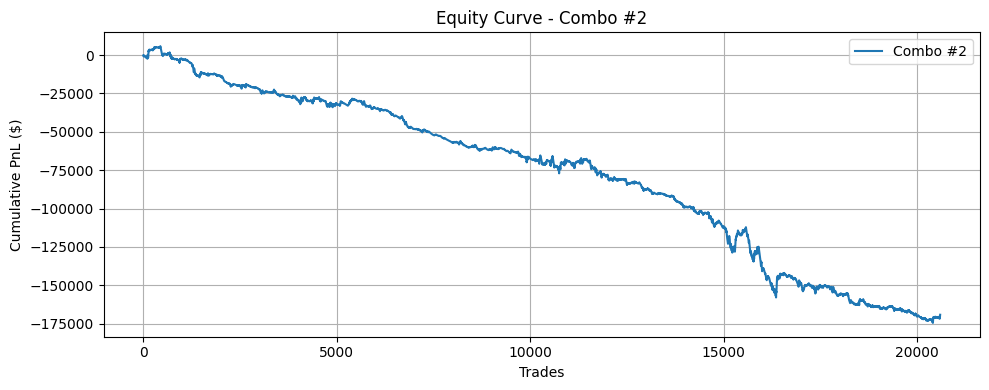


📊 Combo Overlap Matrix (Top 5 Combos):
['rsi', 'chop_index', 'volume_delta_ema'] vs ['rsi', 'chop_index', 'vwap_diff'] → Overlap: 100.00%
['rsi', 'chop_index', 'volume_delta_ema'] vs ['rsi', 'chop_index', 'body_pct'] → Overlap: 100.00%
['rsi', 'chop_index', 'volume_delta_ema'] vs ['rsi', 'chop_index', 'upper_wick'] → Overlap: 100.00%
['rsi', 'chop_index', 'volume_delta_ema'] vs ['rsi', 'chop_index', 'lower_wick'] → Overlap: 100.00%
['rsi', 'chop_index', 'vwap_diff'] vs ['rsi', 'chop_index', 'body_pct'] → Overlap: 100.00%
['rsi', 'chop_index', 'vwap_diff'] vs ['rsi', 'chop_index', 'upper_wick'] → Overlap: 100.00%
['rsi', 'chop_index', 'vwap_diff'] vs ['rsi', 'chop_index', 'lower_wick'] → Overlap: 100.00%
['rsi', 'chop_index', 'body_pct'] vs ['rsi', 'chop_index', 'upper_wick'] → Overlap: 100.00%
['rsi', 'chop_index', 'body_pct'] vs ['rsi', 'chop_index', 'lower_wick'] → Overlap: 100.00%
['rsi', 'chop_index', 'upper_wick'] vs ['rsi', 'chop_index', 'lower_wick'] → Overlap: 100.00%

📊 Combo

In [ ]:
import json

filtered = [s for s in combo_stats if s['win_rate'] >= 0.2]
sorted_combos = sorted(
    filtered,
    key=lambda x: (
        x['pnl'],
        x['trades'],
        x['win_rate'],
        x['avg_mfe'],
        -x['avg_mae'],
        -x['max_loss']
    ),
    reverse=True
)
top_2 = sorted_combos[:2]
best_combo = sorted_combos[0]
best_threshold = best_combo['threshold']
best_confidence = best_combo['confidence']
print(f"\n🏆 Best Overall Threshold: {best_threshold}")
print(f"📈 Best Overall Confidence: {best_confidence}")

best_config = {
    'features': best_combo['features'],
    'confidence': best_combo['confidence'],
    'threshold': best_combo['threshold'],
    'expectancy': best_combo['expectancy'],
    'profit_factor': best_combo['profit_factor'],
    'sharpe': best_combo['sharpe'],
    'pnl': best_combo['pnl'],
    'trades': best_combo['trades'],
    'win_rate': best_combo['win_rate'],
}

with open("best_strategy.json", "w") as f:
    json.dump(best_config, f, indent=4)

print("✅ Exported best strategy configuration to `best_strategy.json`")

for i, combo in enumerate(top_2):
    print(f"\n🔥 Top Combo #{i+1} | Confidence={combo['confidence']}: {combo['features']} | PnL=${combo['pnl']:.2f}, Trades={combo['trades']}, WinRate={combo['win_rate']:.2%}, MFE={combo['avg_mfe']:.2f}, MAE={combo['avg_mae']:.2f}, MaxWin=${combo['max_win']:.2f}, MaxLoss=${combo['max_loss']:.2f}")
    equity_curve = combo['results']['pnl'].cumsum()
    plt.figure(figsize=(10, 4))
    plt.plot(equity_curve, label=f"Combo #{i+1}")
    plt.title(f"Equity Curve - Combo #{i+1}")
    plt.xlabel("Trades")
    plt.ylabel("Cumulative PnL ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n📊 Combo Overlap Matrix (Top 5 Combos):")
for i in range(min(5, len(sorted_combos))):
    for j in range(i + 1, min(5, len(sorted_combos))):
        a = sorted_combos[i]['features']
        b = sorted_combos[j]['features']
        overlap = combo_overlap(a, b)
        print(f"{a} vs {b} → Overlap: {overlap:.2%}")

print("\n📊 Combo Overlap Matrix (Top 5 Combos):")
for i in range(min(5, len(sorted_combos))):
    for j in range(i + 1, min(5, len(sorted_combos))):
        a = sorted_combos[i]['features']
        b = sorted_combos[j]['features']
        overlap = combo_overlap(a, b)
        print(f"{a} vs {b} → Overlap: {overlap:.2%}")

# === Print Summary Table ===
print("\n📋 Feature Combo Summary:")
for stat in sorted_combos[:10]:
    print(f"{stat['features']} | Conf={stat['confidence']} | PnL=${stat['pnl']:.2f}, Trades={stat['trades']}, WinRate={stat['win_rate']:.2%}, MFE={stat['avg_mfe']:.2f}, MAE={stat['avg_mae']:.2f}, MaxWin=${stat['max_win']:.2f}, MaxLoss=${stat['max_loss']:.2f}")

print(f"⛔ Skipped Trades due to avoid filters: {skipped_trades}")

In [ ]:
importances = model.feature_importances_
for feat, imp in sorted(zip(features, importances), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.4f}")

from sklearn.metrics import classification_report
print("Classification report")
print(classification_report(y_test, model.predict(X_test)))

atr_14: 0.1120
volume: 0.1005
volume_delta_ema: 0.0970
rsi: 0.0950
macd: 0.0948
ema_9: 0.0861
vwap_diff: 0.0861
chop_index: 0.0848
ema_21: 0.0819
lower_wick: 0.0568
body_pct: 0.0528
upper_wick: 0.0521
Classification report
              precision    recall  f1-score   support

        -2.0       0.41      0.26      0.32     48565
        -1.0       0.09      0.39      0.15     11271
         0.0       0.09      0.08      0.09     10285
         1.0       0.10      0.10      0.10     12945
         2.0       0.34      0.19      0.25     40263

    accuracy                           0.22    123329
   macro avg       0.21      0.20      0.18    123329
weighted avg       0.30      0.22      0.24    123329

